### Calculate and Plot Fermi beta angle

### <span style="color:red; font-family:Georgia;">Robert Cameron, May 2017</span>

Based on the python implementation of SGP4 orbit propagator
available at https://pypi.python.org/pypi/sgp4/

In [1]:
# set the output directory for output text files and plots
outdir = "/Users/rac/Documents/GLAST/ISOC/LATmetrics/beta/"

In [2]:
import numpy as np
import re
import urllib
from math import *
# the matplotlib notebook magic line must be before the matplotlib imports
%matplotlib inline
import matplotlib.pyplot as plt, mpld3
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import sys
from os.path import expanduser
HOME = expanduser("~")
sys.path.append(HOME+'/Documents/GLAST/sgp4-1.4')
from sgp4.earth_gravity import wgs84
from sgp4.io import twoline2rv
from sgp4.ext import jday, invjday, days2mdhms
import datetime as dt     

In [3]:
# get today's date and Julian Day number

today = str(dt.date.today())
y, m, d = today.split("-")
y = int(y)
m = int(m)
d = int(d)
jtoday = jday(y,m,d,0,0,0)
ymdhms = dt.datetime(y,m,d,0,0,0)
doy = ymdhms.strftime('%j')
today, y, m, d, jtoday, ymdhms, doy

('2020-03-26',
 2020,
 3,
 26,
 2458934.5,
 datetime.datetime(2020, 3, 26, 0, 0),
 '086')

In [4]:
# get latest TLE (Two Line Elements) for Fermi orbit

webTLE = "http://celestrak.com/NORAD/elements/science.txt"
lines = urllib.request.urlopen(webTLE).readlines()
regex = re.compile(b'(1|2) 33053')
tle = [x.decode().replace('\r\n', '') for x in lines if regex.match(x)]
tle

['1 33053U 08029A   20086.31476239  .00000517  00000-0  12799-4 0  9999',
 '2 33053  25.5830 306.5396 0012587 124.5516 235.6208 15.11317312650741']

In [5]:
# use WGS84 Earth Coordinate System in TLE propagation
satellite = twoline2rv(tle[0], tle[1], wgs84)

In [6]:
# propagate Fermi orbit and calculate beta angle at 1-hour intervals
# save data to a text file

oformat = "%4d %02d %02d %02d %02d %02d %12.5f %12.6f %12.6f %12.6f %8.3f\n"
fo = open(outdir+"beta_"+today+".txt", "w")
fo.write("Year MonDay H M  S     FDOY     X(km)      Y(km)       Z(km)     beta(deg)\n")
datepl = []
betapl = []
for day in range(-30,70):
    jd0 = jtoday + day
    for hour in range(24):
# add a small amount to the day number to ensure it is always a small fraction of a second past the hour
        jd = jd0 + hour/24.0 + 1.0e-9
        (y,mon,d,h,m,s) = invjday(jd)    # need Julian Day for the Sun ephemeris
        ymdhms = dt.datetime(y,mon,d,hour,0,0)
        doy = ymdhms.strftime('%j')
        fdoy = int(doy) + hour/24.0
        datepl.append(ymdhms)
        pos, vel = satellite.propagate(y,mon,d,hour,0,0)  # this is the key line to specify the date
        pole = np.cross(pos,vel)
        polelen = np.linalg.norm(pole)
# calculate Sun coordinates. See (for example): https://en.wikipedia.org/wiki/Position_of_the_Sun
        n = jd - 2451545.0
        L = (280.460 + 0.9856474 * n) % 360
        g = radians((357.528 + 0.9856003 * n) % 360)
        lamda = radians(L + 1.915 * sin(g) + 0.020 * sin(2*g))
        epsilon = radians(23.439 - 0.0000004 * n)
        Xsun = cos(lamda)
        Ysun = cos(epsilon) * sin(lamda)
        Zsun = sin(epsilon) * sin(lamda)
        dotprod = np.dot([Xsun,Ysun,Zsun], pole)
        beta = degrees(np.arcsin(dotprod/polelen))
        betapl.append(beta)
        fo.write(oformat % (y, mon, d, hour, 0, 0, fdoy, pos[0], pos[1], pos[2], beta))
fo.close()

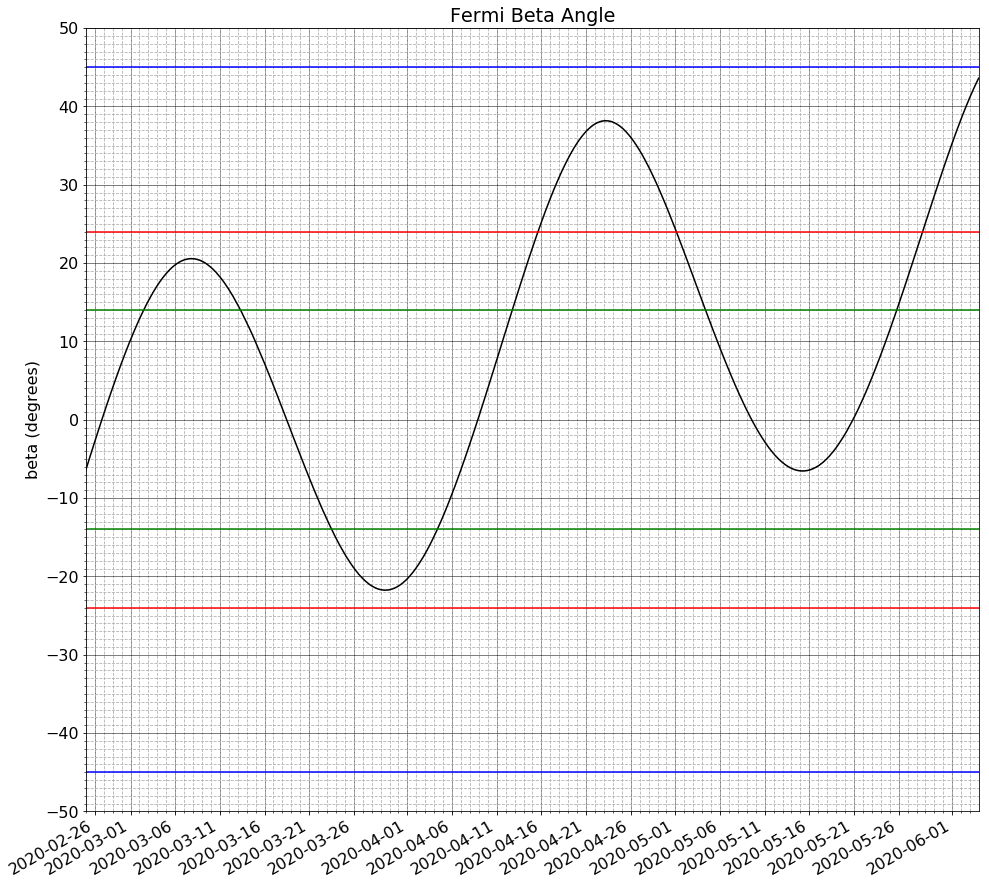

In [34]:
plt.rc('font', size = 16)
#fig, ax = plt.subplots(figsize = [10, 8.5])
fig = plt.figure(figsize = [16,16])
ax = fig.add_subplot(111)

ax.set_ylim(-50,50)
ax.grid('on',which='major', axis='both', linewidth=0.5, color='k')
ax.grid('on',which='minor', axis='both',linestyle = 'dashed')
ax.plot(datepl, betapl, label = 'Beta angle', color = 'k')
ax.set_ylabel('beta (degrees)', color = 'k')
ax.set_title('Fermi Beta Angle')

# set minor ticks on plot
minorLocatorx = AutoMinorLocator(1)
minorLocatory = AutoMinorLocator(10)

ax.xaxis.set_minor_locator(minorLocatorx)
ax.yaxis.set_minor_locator(minorLocatory)

ax.yaxis.set_major_locator(MultipleLocator(10))

#plt.gca().xaxis.set_major_locator(mdates.DayLocator((1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31)))
plt.gca().xaxis.set_major_locator(mdates.DayLocator((1,6,11,16,21,26)))

ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.gca().xaxis.set_minor_locator(mdates.DayLocator(interval=1))

#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%b-%d"))
plt.gcf().autofmt_xdate()

xminmax = [datepl[0],datepl[-1]]

ax.plot(xminmax,[-45,-45], color = 'b')
ax.plot(xminmax,[45,45], color = 'b')
ax.plot(xminmax,[-24,-24], color = 'r')
ax.plot(xminmax,[24,24], color = 'r')
ax.plot(xminmax,[-14,-14], color = 'g')
ax.plot(xminmax,[14,14], color = 'g')

# turn off plot margin along the X-axis of the plot
ax.margins(x=0)

#mpld3.enable_notebook()

In [35]:
plt.savefig(outdir+'beta_'+today+'.png')

<Figure size 432x288 with 0 Axes>